
This notebook was adopted from this notebook at: https://github.com/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/awkward-GAN-with-no-warning.ipynb


```
# This is formatted as code
```



In [1]:
# for data input and output:
import numpy as np
import os

# for deep learning:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout, Lambda
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape # new!
from keras.layers import Conv2DTranspose, UpSampling2D # new!
from keras.optimizers import RMSprop # new!
from keras import backend as K

# for plotting:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import numpy as np

file_path = '/content/drive/MyDrive/full_numpy_bitmap_book.npy'
data = np.load(file_path)


In [11]:
data.shape

(119364, 784)

In [12]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) # fourth dimension is color
img_w,img_h = data.shape[1:3]
# data.shape

In [13]:
data.shape

(119364, 28, 28, 1)

Create Discriminator Network

In [14]:
def build_discriminator(depth=64, p=0.4):

    # Define inputs
    image = Input((img_w,img_h,1))

    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2,
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)

    conv2 = Conv2D(depth*2, 5, strides=2,
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)

    conv3 = Conv2D(depth*4, 5, strides=2,
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)

    conv4 = Conv2D(depth*8, 5, strides=1,
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))

    # Output layer
    prediction = Dense(1, activation='sigmoid', name='prediction')(conv4)

    # Model definition
    model = Model(inputs=image, outputs=prediction)

    return model

In [15]:
discriminator = build_discriminator()

In [21]:
from tensorflow.keras.optimizers.legacy import RMSprop

In [22]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(learning_rate=0.0008,
                                        decay=6e-8,
                                        clipvalue=1.0),
                      metrics=['binary_accuracy'])

In [23]:
# Build an identical discriminator:
discriminator_ = build_discriminator()

# Set the model so that its parameters are frozen:
discriminator_.trainable = False

In [24]:
# Function to copy the weights from the trainable discriminator to the frozen discriminator_
def copy_weights(source, target):
    for i, layer in enumerate(source.layers):
        target.layers[i].set_weights(source.layers[i].get_weights())


**Create a Generator Network**

In [25]:
z_dimensions = 32

In [26]:
def build_generator(latent_dim=z_dimensions,
                    depth=64, p=0.4):

    # Define inputs
    noise = Input((latent_dim,))

    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)

    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2),
                            kernel_size=5, padding='same',
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)

    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4),
                            kernel_size=5, padding='same',
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)

    conv3 = Conv2DTranspose(int(depth/8),
                            kernel_size=5, padding='same',
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same',
                   activation='sigmoid')(conv3)

    # Model definition
    model = Model(inputs=noise, outputs=image)

    return model

In [27]:
generator = build_generator()


Create adversarial network

In [28]:
def build_adversarial():

    # Define input
    z = Input(shape=(z_dimensions,))

    # Generate image from noise
    img = generator(z)

    # Make prediction
    pred = discriminator_(img)

    # Build model
    model = Model(inputs=z, outputs=pred)

    return model

In [29]:
adversarial_model = build_adversarial()

In [30]:
adversarial_model.compile(loss='binary_crossentropy',
                          optimizer=RMSprop(lr=0.0004,
                                            decay=3e-8,
                                            clipvalue=1.0),
                          metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


**Train it**

In [31]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):

    d_metrics = []
    a_metrics = []

    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0

    for i in range(epochs):

        #######################
        # train discriminator:#
        #######################

        # sample real images:
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,1))

        # generate fake images:
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0,
                              size=[batch, z_dim]))

        # concatenate images as discriminator inputs:
        x = np.concatenate((real_imgs,fake_imgs))

        # assign y labels for discriminator:
        # Added noisy labels, as per here: https://link.medium.com/yUuw4Y33PX
        # Note: disciminator accuracy will always be zero now...
        y = np.ones([2*batch,1]) - np.random.uniform(0,0.1,[2*batch,1])
        y[batch:,:] = 0
        y[batch:,:] += np.random.uniform(0,0.1,[batch,1])

        # do training
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]

        #########################
        # train adversarial net:#
        #########################

        # adversarial net's noise input and "real" y:
        noise = np.random.uniform(-1.0, 1.0,
                                  size=[batch, z_dim])
        y = np.ones([batch,1])
         #Copy weights to frozen discriminator
        copy_weights(discriminator, discriminator_)

        # do training
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        )
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]

        #########################
        #     Print results     #
        #########################

        # periodically print progress & fake images:
        if (i+1)%20 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0,
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0],
                           cmap='gray')
                plt.axis('off')

            plt.tight_layout()
            plt.show()

    return a_metrics, d_metrics

4/4 [==============================] - 0s 3ms/step
Epoch #19
19: [D loss: 1.249453, acc: 0.000000]  [A loss: 1.335193, acc: 0.431743]
1/1 [==============================] - 0s 271ms/step


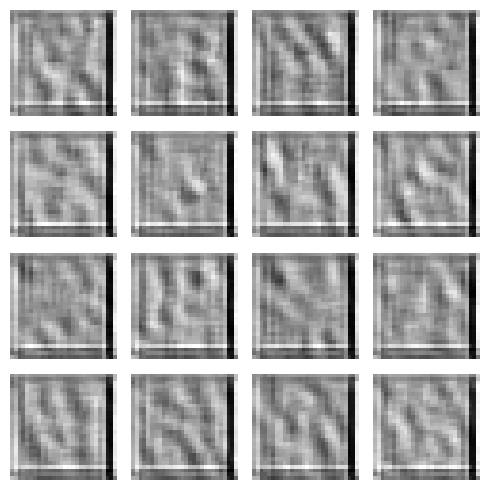

4/4 [==============================] - 0s 3ms/step
Epoch #39
39: [D loss: 0.740217, acc: 0.000000]  [A loss: 0.969905, acc: 0.606771]
1/1 [==============================] - 0s 17ms/step


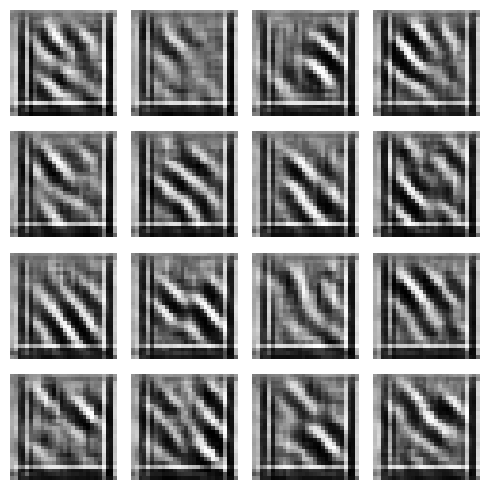

4/4 [==============================] - 0s 3ms/step
Epoch #59
59: [D loss: 0.622809, acc: 0.000000]  [A loss: 1.240532, acc: 0.460011]
1/1 [==============================] - 0s 25ms/step


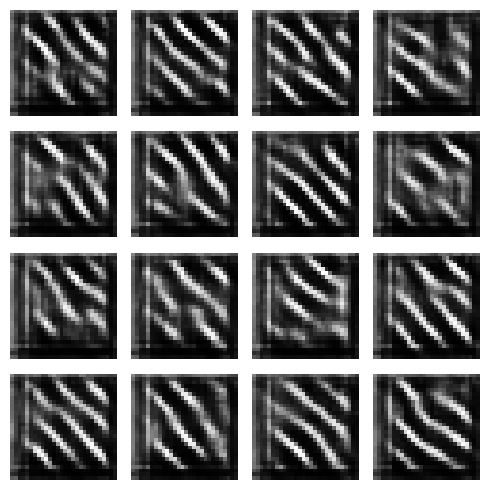

4/4 [==============================] - 0s 4ms/step
Epoch #79
79: [D loss: 0.596026, acc: 0.000000]  [A loss: 1.365930, acc: 0.428105]
1/1 [==============================] - 0s 17ms/step


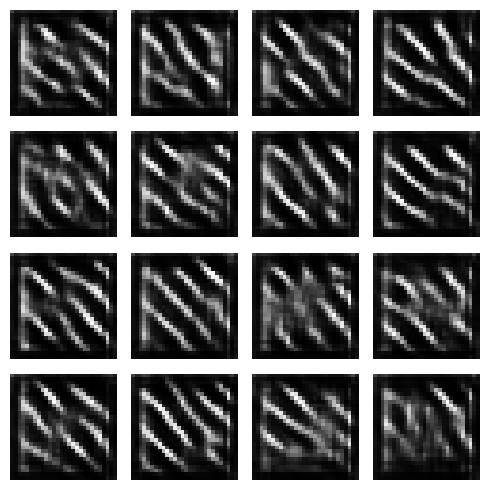

4/4 [==============================] - 0s 3ms/step
Epoch #99
99: [D loss: 0.538305, acc: 0.000000]  [A loss: 1.565983, acc: 0.361506]
1/1 [==============================] - 0s 16ms/step


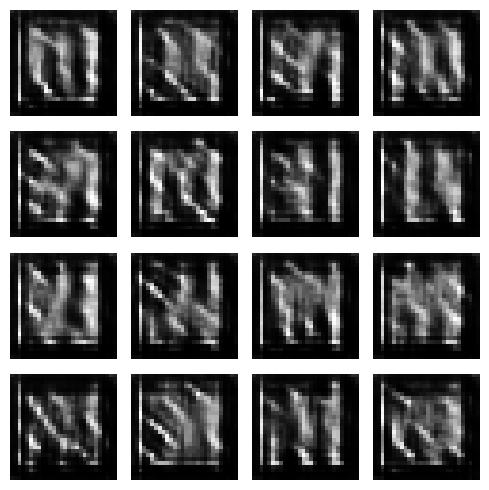

4/4 [==============================] - 0s 4ms/step
Epoch #119
119: [D loss: 0.508223, acc: 0.000000]  [A loss: 1.723288, acc: 0.306394]
1/1 [==============================] - 0s 31ms/step


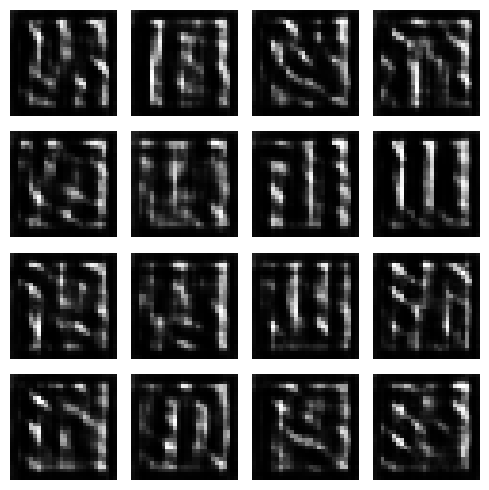

4/4 [==============================] - 0s 3ms/step
Epoch #139
139: [D loss: 0.484449, acc: 0.000000]  [A loss: 1.915211, acc: 0.275517]
1/1 [==============================] - 0s 17ms/step


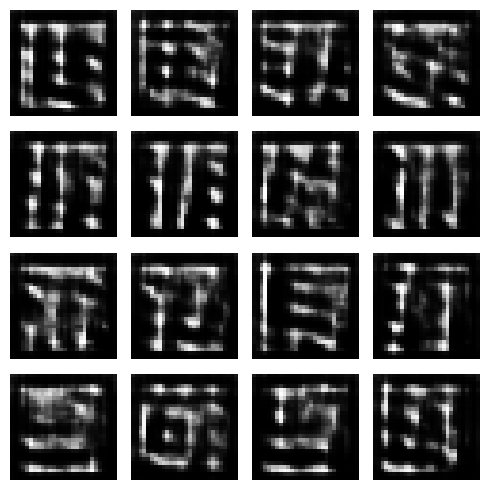

4/4 [==============================] - 0s 3ms/step
Epoch #159
159: [D loss: 0.462959, acc: 0.000000]  [A loss: 2.040248, acc: 0.247445]
1/1 [==============================] - 0s 20ms/step


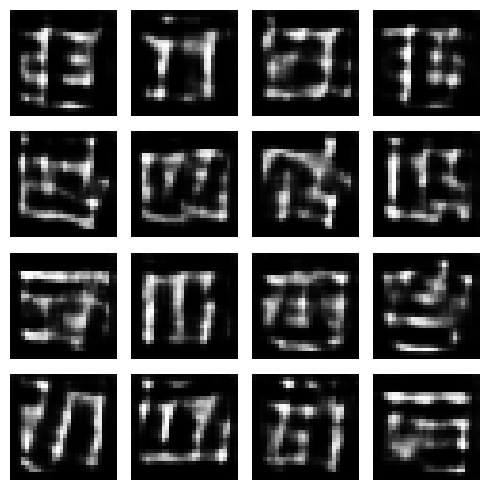

4/4 [==============================] - 0s 5ms/step
Epoch #179
179: [D loss: 0.449042, acc: 0.000000]  [A loss: 2.110243, acc: 0.225079]
1/1 [==============================] - 0s 25ms/step


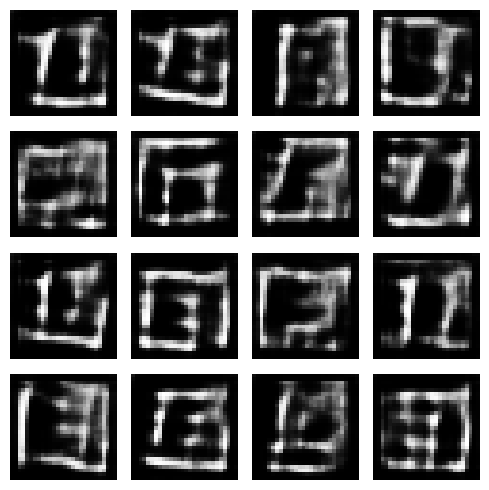

4/4 [==============================] - 0s 3ms/step
Epoch #199
199: [D loss: 0.441531, acc: 0.000000]  [A loss: 2.151368, acc: 0.206815]
1/1 [==============================] - 0s 21ms/step


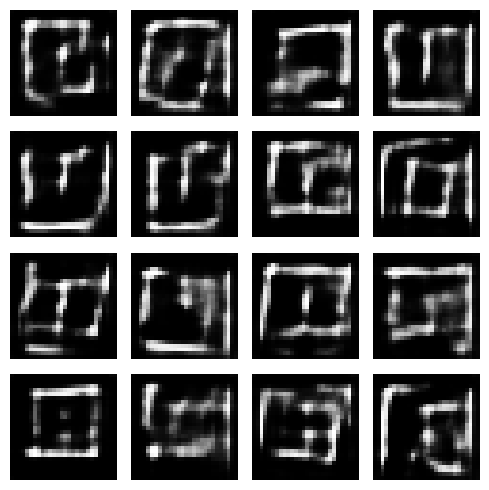

4/4 [==============================] - 0s 3ms/step
Epoch #219
219: [D loss: 0.437469, acc: 0.000000]  [A loss: 2.173773, acc: 0.193101]
1/1 [==============================] - 0s 17ms/step


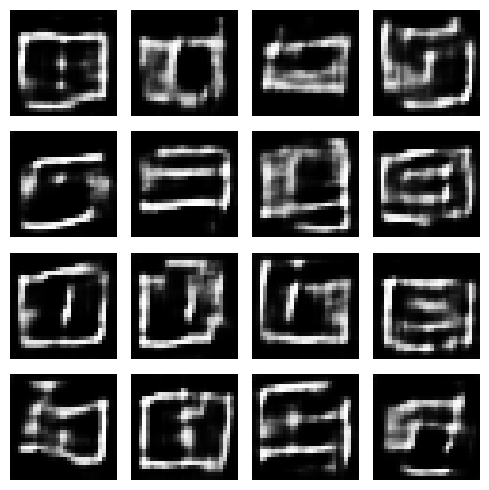

4/4 [==============================] - 0s 3ms/step
Epoch #239
239: [D loss: 0.433002, acc: 0.000000]  [A loss: 2.164311, acc: 0.182760]
1/1 [==============================] - 0s 16ms/step


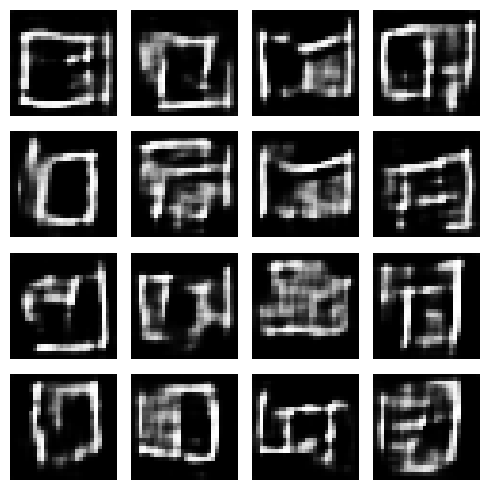

4/4 [==============================] - 0s 3ms/step
Epoch #259
259: [D loss: 0.428818, acc: 0.000000]  [A loss: 2.158662, acc: 0.178240]
1/1 [==============================] - 0s 17ms/step


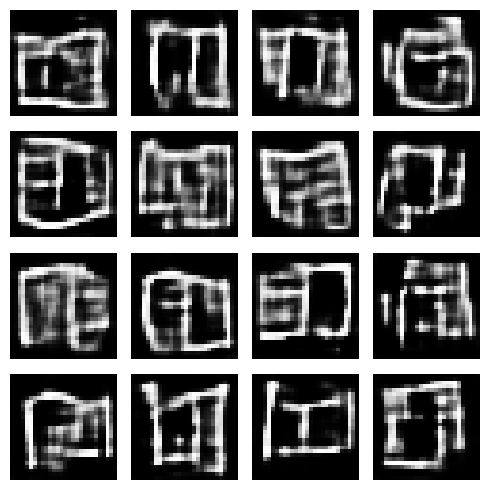

4/4 [==============================] - 0s 3ms/step
Epoch #279
279: [D loss: 0.432333, acc: 0.000000]  [A loss: 2.130930, acc: 0.174367]
1/1 [==============================] - 0s 17ms/step


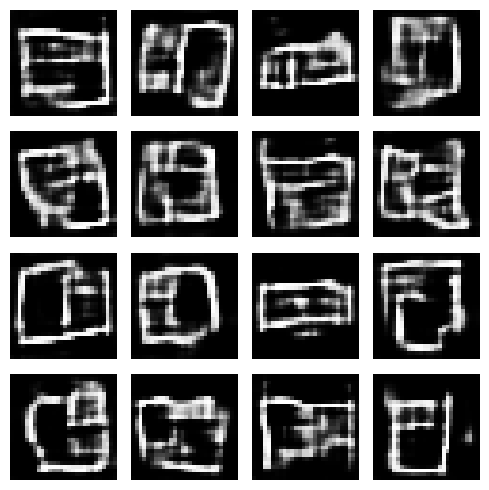

4/4 [==============================] - 0s 4ms/step
Epoch #299
299: [D loss: 0.431699, acc: 0.000000]  [A loss: 2.103015, acc: 0.174148]
1/1 [==============================] - 0s 17ms/step


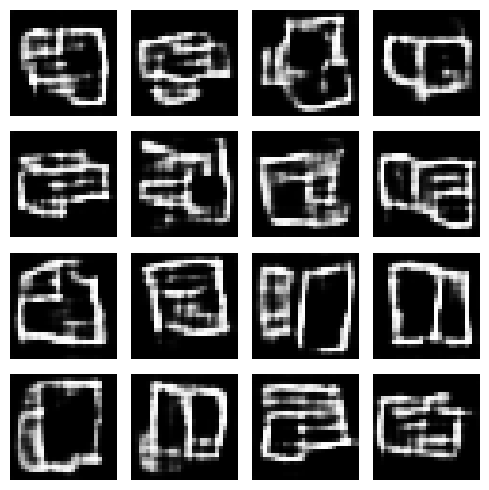

4/4 [==============================] - 0s 3ms/step
Epoch #319
319: [D loss: 0.435113, acc: 0.000000]  [A loss: 2.072391, acc: 0.174251]
1/1 [==============================] - 0s 17ms/step


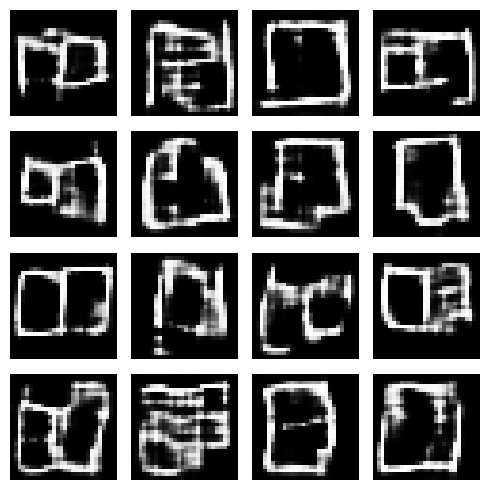

4/4 [==============================] - 0s 4ms/step
Epoch #339
339: [D loss: 0.438102, acc: 0.000000]  [A loss: 2.046401, acc: 0.174917]
1/1 [==============================] - 0s 24ms/step


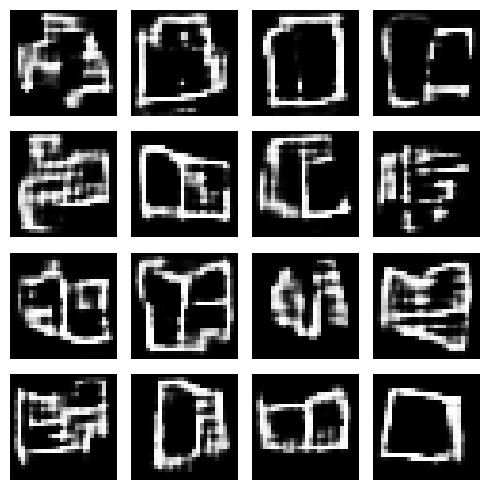

4/4 [==============================] - 0s 3ms/step
Epoch #359
359: [D loss: 0.439282, acc: 0.000000]  [A loss: 2.027926, acc: 0.174095]
1/1 [==============================] - 0s 23ms/step


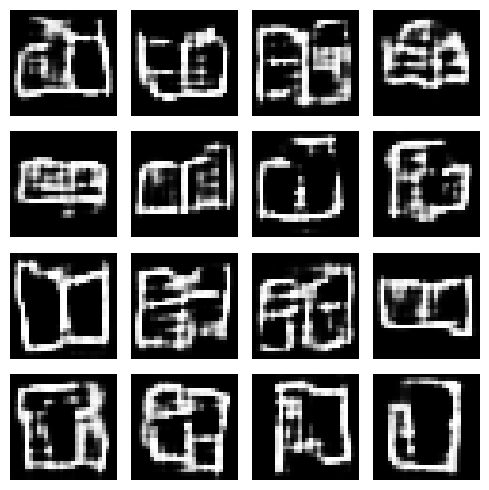

4/4 [==============================] - 0s 3ms/step
Epoch #379
379: [D loss: 0.440191, acc: 0.000000]  [A loss: 2.014676, acc: 0.172328]
1/1 [==============================] - 0s 23ms/step


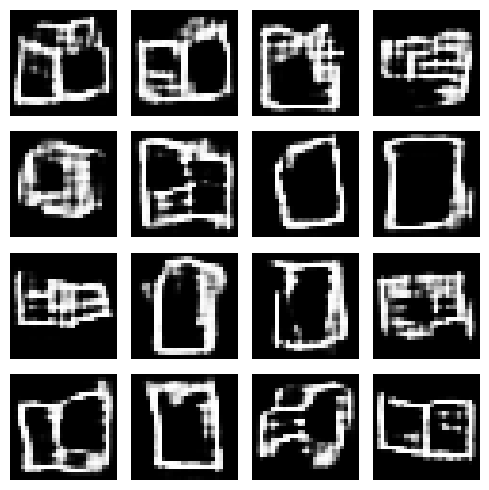

4/4 [==============================] - 0s 3ms/step
Epoch #399
399: [D loss: 0.442705, acc: 0.000000]  [A loss: 1.998089, acc: 0.171092]
1/1 [==============================] - 0s 25ms/step


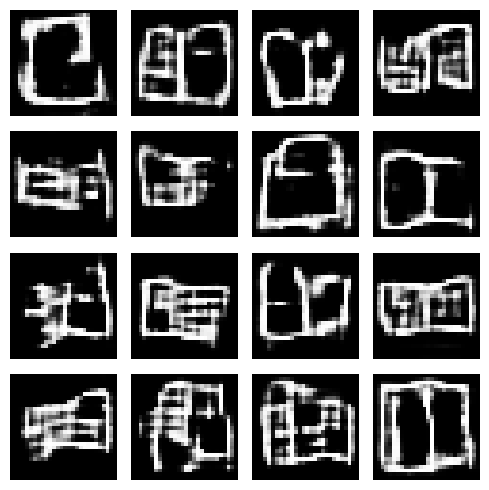

4/4 [==============================] - 0s 5ms/step
Epoch #419
419: [D loss: 0.444007, acc: 0.000000]  [A loss: 1.986376, acc: 0.168966]
1/1 [==============================] - 0s 19ms/step


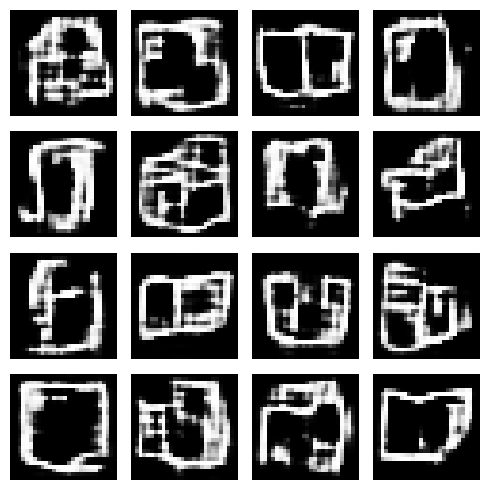

4/4 [==============================] - 0s 4ms/step
Epoch #439
439: [D loss: 0.445427, acc: 0.000000]  [A loss: 1.977110, acc: 0.167586]
1/1 [==============================] - 0s 17ms/step


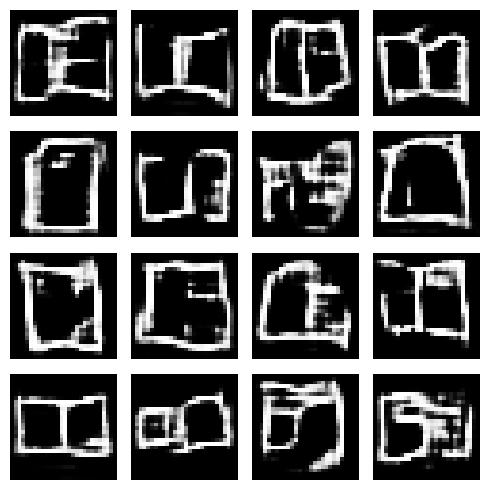

4/4 [==============================] - 0s 4ms/step
Epoch #459
459: [D loss: 0.446066, acc: 0.000000]  [A loss: 1.971286, acc: 0.166071]
1/1 [==============================] - 0s 26ms/step


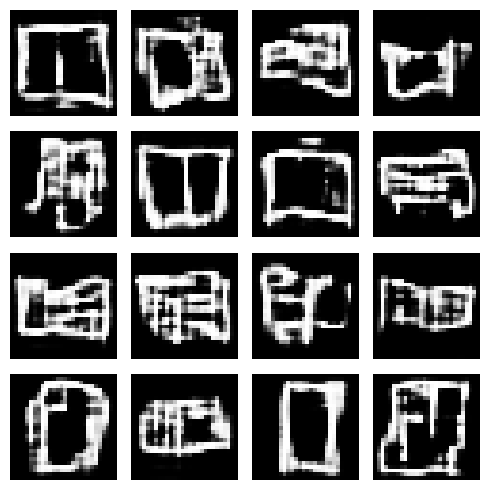

4/4 [==============================] - 0s 4ms/step
Epoch #479
479: [D loss: 0.445474, acc: 0.000000]  [A loss: 1.970075, acc: 0.164177]
1/1 [==============================] - 0s 21ms/step


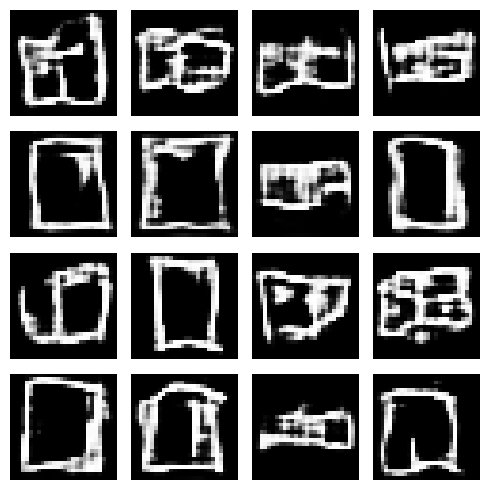

4/4 [==============================] - 0s 3ms/step
Epoch #499
499: [D loss: 0.444584, acc: 0.000000]  [A loss: 1.967868, acc: 0.162747]
1/1 [==============================] - 0s 17ms/step


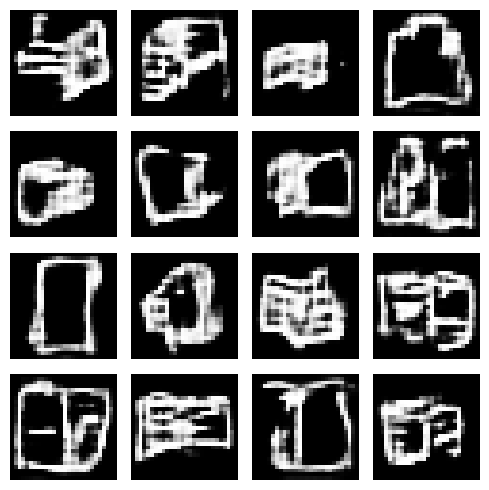

4/4 [==============================] - 0s 3ms/step
Epoch #519
519: [D loss: 0.443879, acc: 0.000000]  [A loss: 1.965782, acc: 0.160916]
1/1 [==============================] - 0s 19ms/step


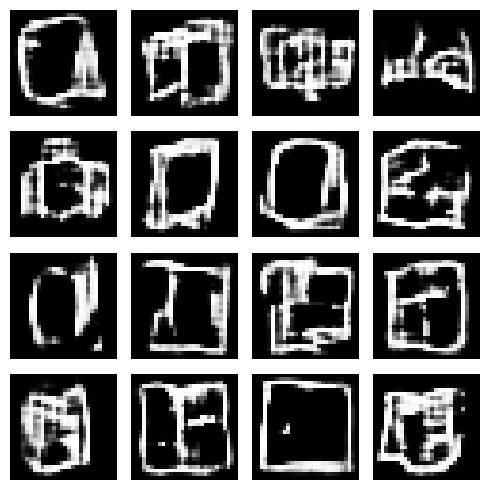

4/4 [==============================] - 0s 4ms/step
Epoch #539
539: [D loss: 0.442782, acc: 0.000000]  [A loss: 1.965671, acc: 0.158787]
1/1 [==============================] - 0s 17ms/step


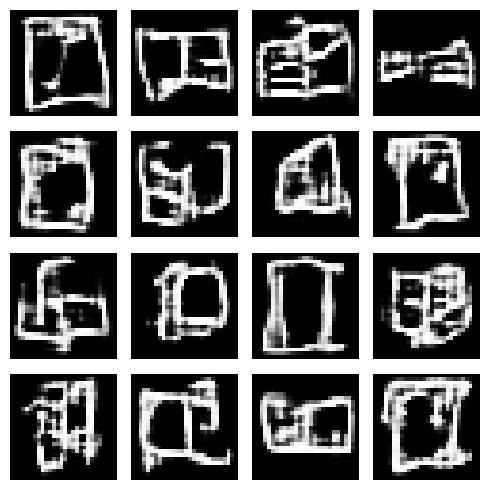

4/4 [==============================] - 0s 3ms/step
Epoch #559
559: [D loss: 0.441974, acc: 0.000000]  [A loss: 1.965676, acc: 0.157298]
1/1 [==============================] - 0s 24ms/step


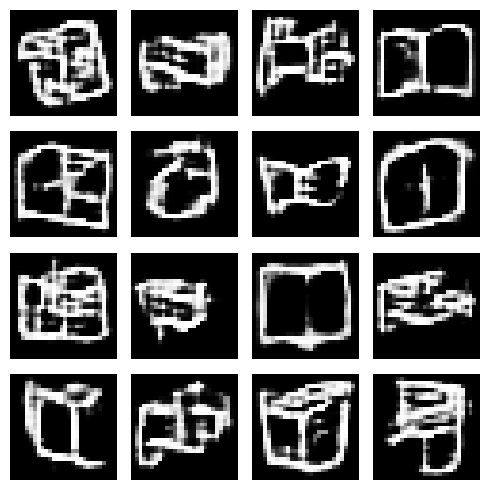

4/4 [==============================] - 0s 4ms/step
Epoch #579
579: [D loss: 0.441418, acc: 0.000000]  [A loss: 1.967408, acc: 0.155629]
1/1 [==============================] - 0s 18ms/step


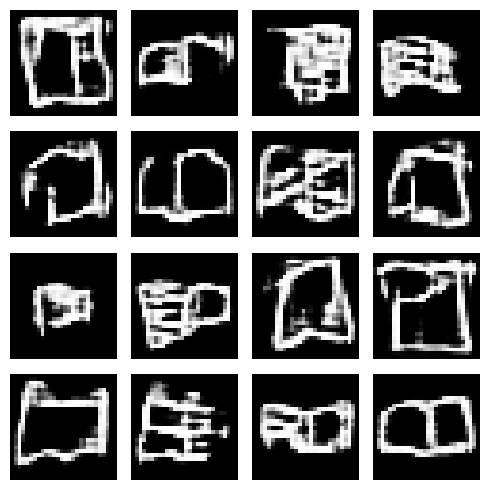

4/4 [==============================] - 0s 3ms/step
Epoch #599
599: [D loss: 0.440715, acc: 0.000000]  [A loss: 1.967194, acc: 0.153172]
1/1 [==============================] - 0s 19ms/step


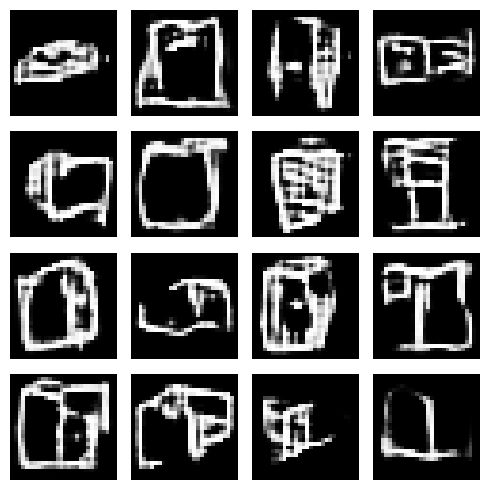

4/4 [==============================] - 0s 3ms/step
Epoch #619
619: [D loss: 0.439755, acc: 0.000000]  [A loss: 1.968141, acc: 0.151441]
1/1 [==============================] - 0s 25ms/step


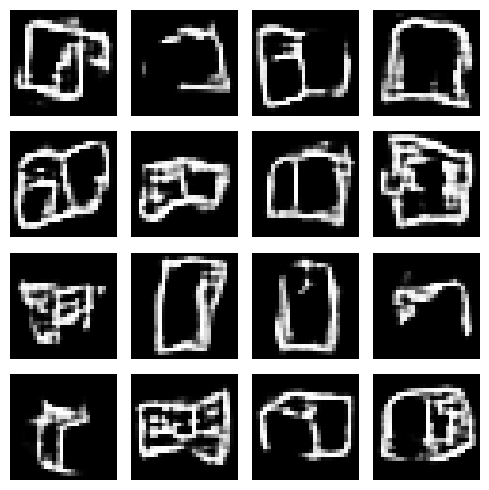

4/4 [==============================] - 0s 3ms/step
Epoch #639
639: [D loss: 0.438635, acc: 0.000000]  [A loss: 1.972591, acc: 0.149648]
1/1 [==============================] - 0s 23ms/step


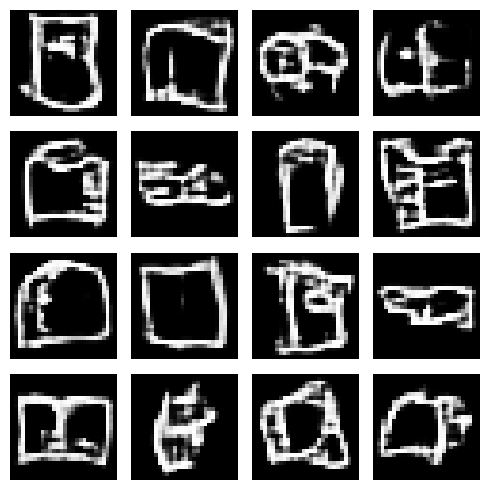

4/4 [==============================] - 0s 3ms/step
Epoch #659
659: [D loss: 0.437704, acc: 0.000000]  [A loss: 1.975228, acc: 0.147963]
1/1 [==============================] - 0s 17ms/step


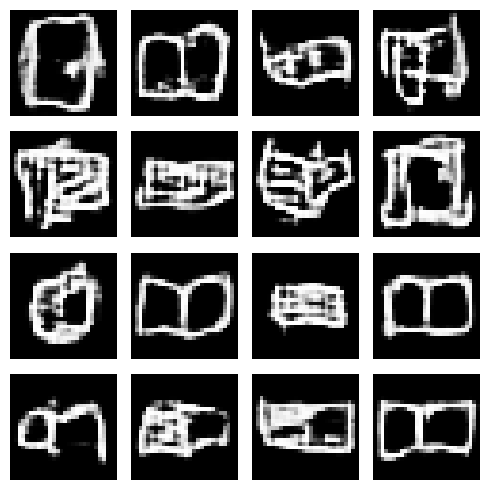

4/4 [==============================] - 0s 3ms/step
Epoch #679
679: [D loss: 0.436659, acc: 0.000000]  [A loss: 1.979666, acc: 0.146343]
1/1 [==============================] - 0s 25ms/step


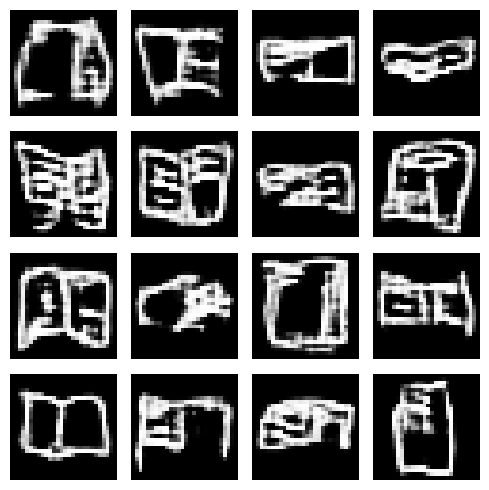

4/4 [==============================] - 0s 3ms/step
Epoch #699
699: [D loss: 0.435330, acc: 0.000000]  [A loss: 1.985379, acc: 0.144716]
1/1 [==============================] - 0s 23ms/step


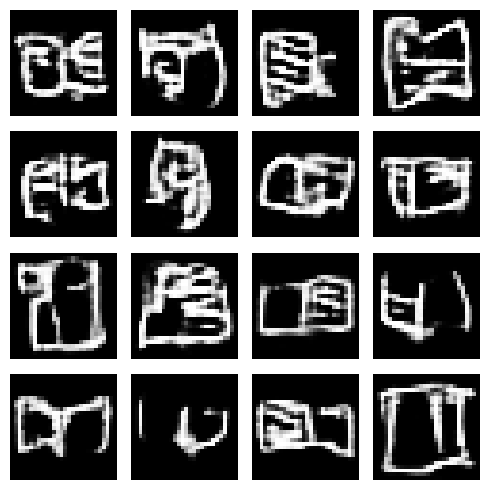

4/4 [==============================] - 0s 3ms/step
Epoch #719
719: [D loss: 0.433880, acc: 0.000000]  [A loss: 1.992957, acc: 0.142874]
1/1 [==============================] - 0s 18ms/step


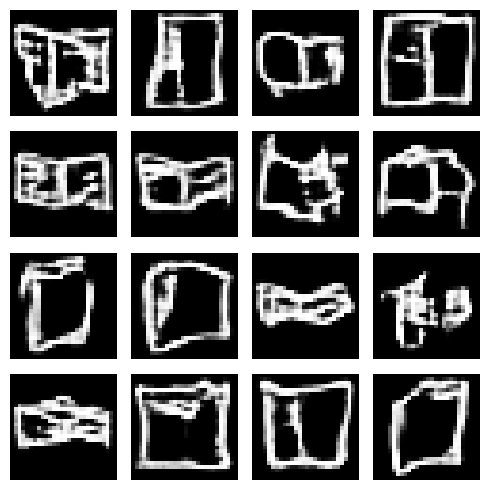

4/4 [==============================] - 0s 3ms/step
Epoch #739
739: [D loss: 0.432723, acc: 0.000000]  [A loss: 1.997886, acc: 0.141354]
1/1 [==============================] - 0s 27ms/step


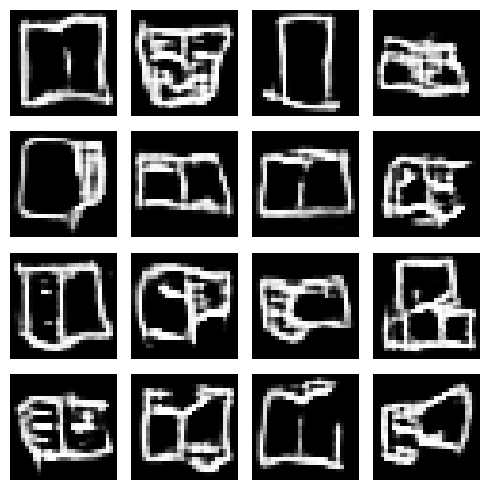

4/4 [==============================] - 0s 3ms/step
Epoch #759
759: [D loss: 0.431511, acc: 0.000000]  [A loss: 2.004479, acc: 0.140193]
1/1 [==============================] - 0s 17ms/step


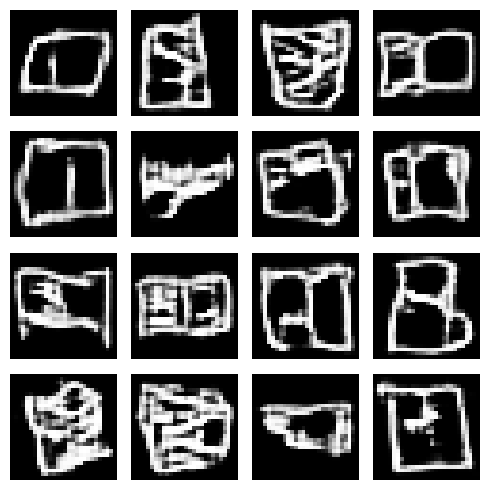

4/4 [==============================] - 0s 3ms/step
Epoch #779
779: [D loss: 0.430268, acc: 0.000000]  [A loss: 2.009549, acc: 0.138679]
1/1 [==============================] - 0s 19ms/step


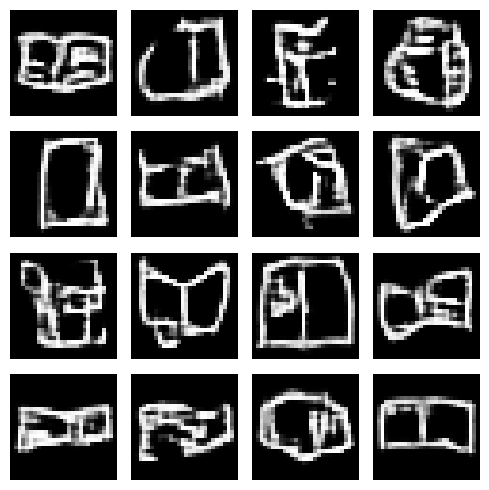

4/4 [==============================] - 0s 4ms/step
Epoch #799
799: [D loss: 0.428761, acc: 0.000000]  [A loss: 2.017393, acc: 0.137076]
1/1 [==============================] - 0s 18ms/step


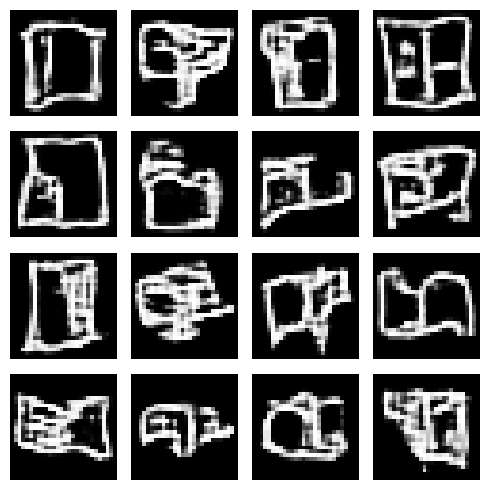

4/4 [==============================] - 0s 4ms/step
Epoch #819
819: [D loss: 0.428172, acc: 0.000000]  [A loss: 2.020767, acc: 0.136037]
1/1 [==============================] - 0s 17ms/step


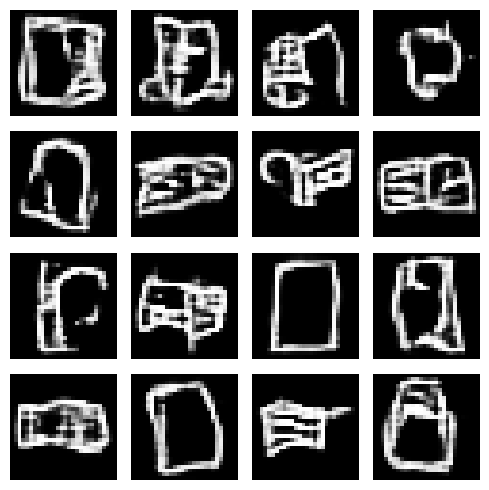

4/4 [==============================] - 0s 4ms/step
Epoch #839
839: [D loss: 0.427114, acc: 0.000000]  [A loss: 2.026423, acc: 0.134517]
1/1 [==============================] - 0s 28ms/step


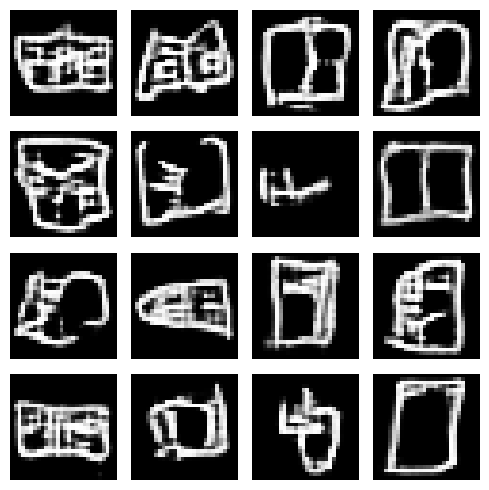

4/4 [==============================] - 0s 4ms/step
Epoch #859
859: [D loss: 0.425997, acc: 0.000000]  [A loss: 2.032834, acc: 0.133404]
1/1 [==============================] - 0s 21ms/step


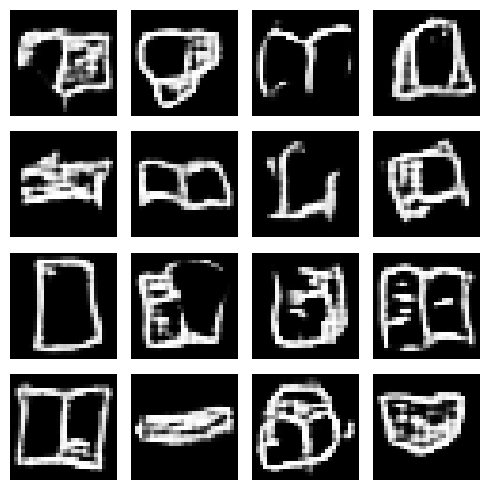

4/4 [==============================] - 0s 4ms/step
Epoch #879
879: [D loss: 0.425011, acc: 0.000000]  [A loss: 2.037211, acc: 0.131959]
1/1 [==============================] - 0s 22ms/step


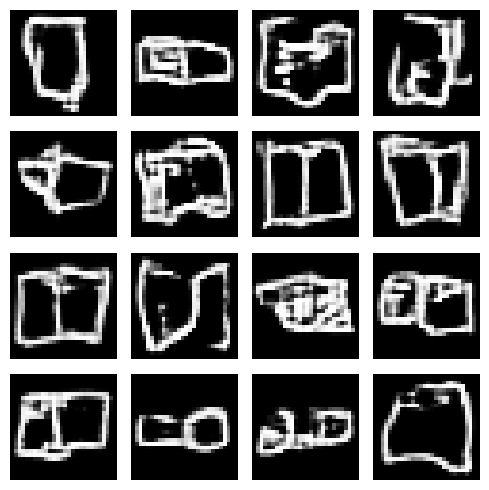

4/4 [==============================] - 0s 3ms/step
Epoch #899
899: [D loss: 0.423715, acc: 0.000000]  [A loss: 2.043961, acc: 0.130666]
1/1 [==============================] - 0s 38ms/step


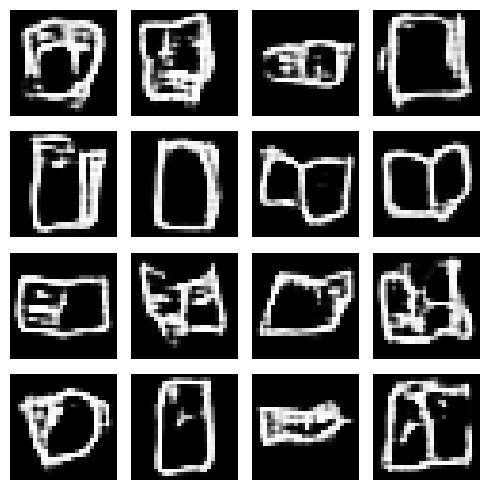

4/4 [==============================] - 0s 3ms/step
Epoch #919
919: [D loss: 0.422830, acc: 0.000000]  [A loss: 2.048675, acc: 0.129667]
1/1 [==============================] - 0s 18ms/step


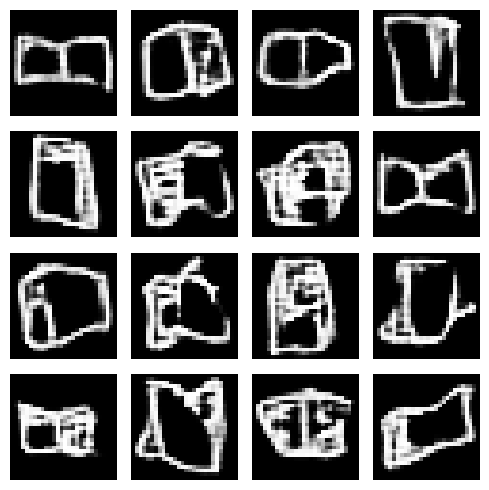

4/4 [==============================] - 0s 3ms/step
Epoch #939
939: [D loss: 0.421162, acc: 0.000000]  [A loss: 2.056405, acc: 0.128361]
1/1 [==============================] - 0s 21ms/step


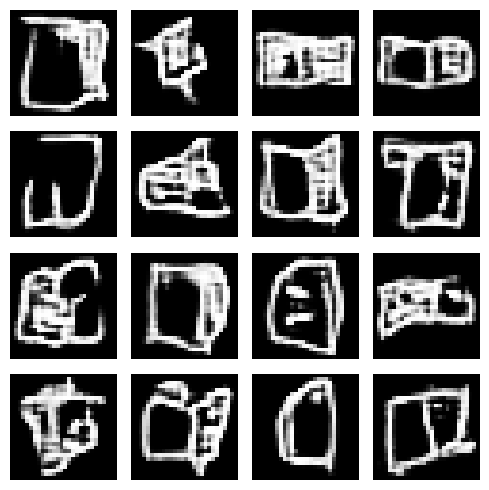

4/4 [==============================] - 0s 4ms/step
Epoch #959
959: [D loss: 0.420307, acc: 0.000000]  [A loss: 2.061490, acc: 0.127468]
1/1 [==============================] - 0s 25ms/step


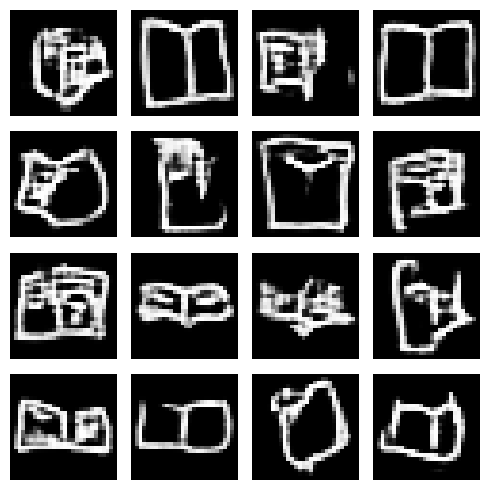

4/4 [==============================] - 0s 4ms/step
Epoch #979
979: [D loss: 0.419115, acc: 0.000000]  [A loss: 2.067529, acc: 0.126293]
1/1 [==============================] - 0s 21ms/step


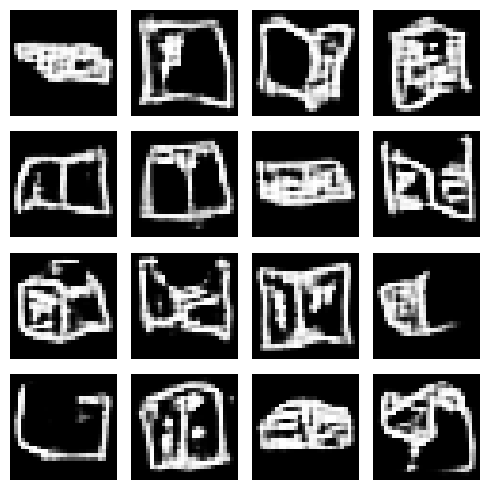

4/4 [==============================] - 0s 3ms/step
Epoch #999
999: [D loss: 0.417916, acc: 0.000000]  [A loss: 2.073622, acc: 0.125047]
1/1 [==============================] - 0s 21ms/step


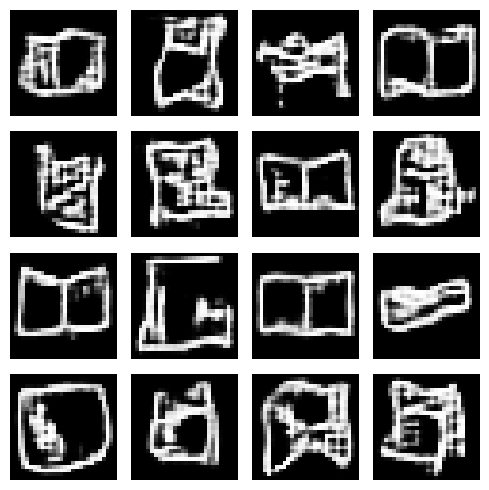

4/4 [==============================] - 0s 3ms/step
Epoch #1019
1019: [D loss: 0.416857, acc: 0.000000]  [A loss: 2.078974, acc: 0.124203]
1/1 [==============================] - 0s 25ms/step


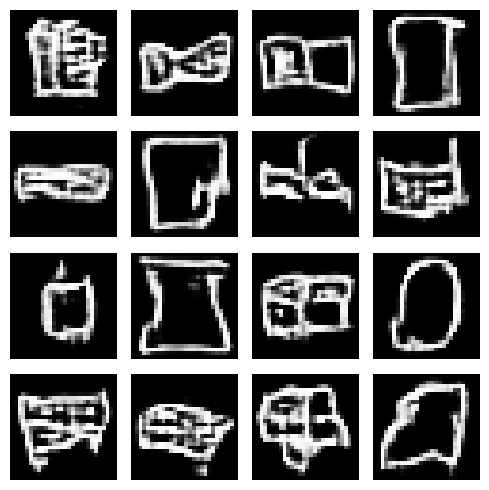

4/4 [==============================] - 0s 3ms/step
Epoch #1039
1039: [D loss: 0.415939, acc: 0.000000]  [A loss: 2.084930, acc: 0.123015]
1/1 [==============================] - 0s 21ms/step


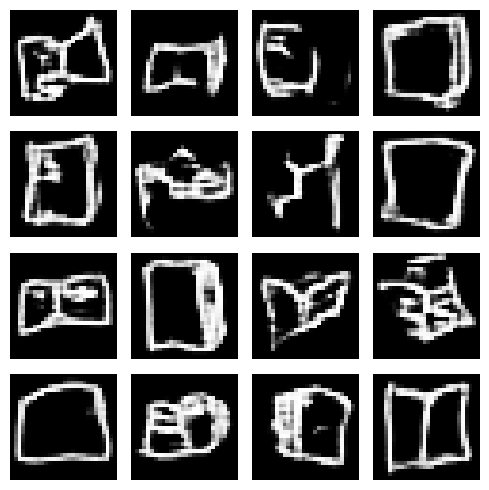

4/4 [==============================] - 0s 4ms/step
Epoch #1059
1059: [D loss: 0.414555, acc: 0.000000]  [A loss: 2.091904, acc: 0.122211]
1/1 [==============================] - 0s 24ms/step


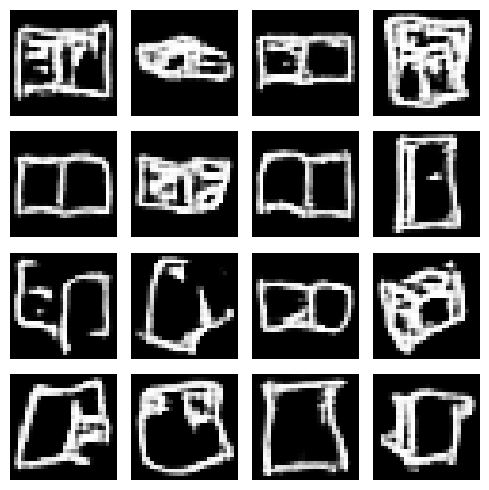

4/4 [==============================] - 0s 3ms/step
Epoch #1079
1079: [D loss: 0.413775, acc: 0.000000]  [A loss: 2.097357, acc: 0.121134]
1/1 [==============================] - 0s 17ms/step


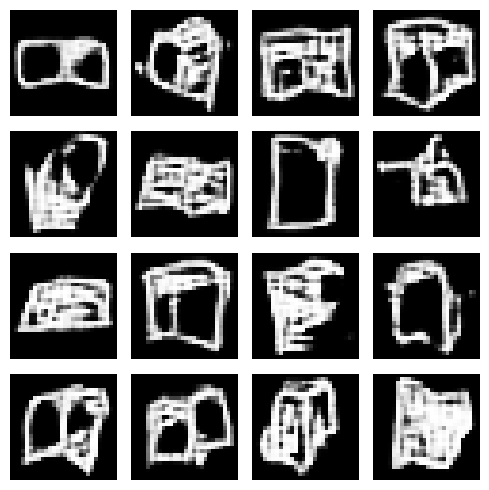

4/4 [==============================] - 0s 3ms/step
Epoch #1099
1099: [D loss: 0.412706, acc: 0.000000]  [A loss: 2.102425, acc: 0.120116]
1/1 [==============================] - 0s 18ms/step


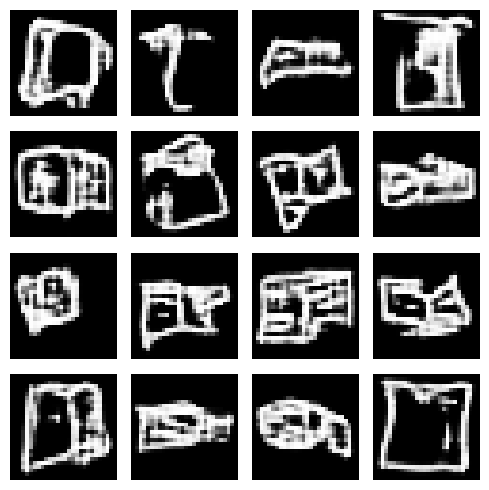

4/4 [==============================] - 0s 4ms/step
Epoch #1119
1119: [D loss: 0.411622, acc: 0.000000]  [A loss: 2.107970, acc: 0.119149]
1/1 [==============================] - 0s 30ms/step


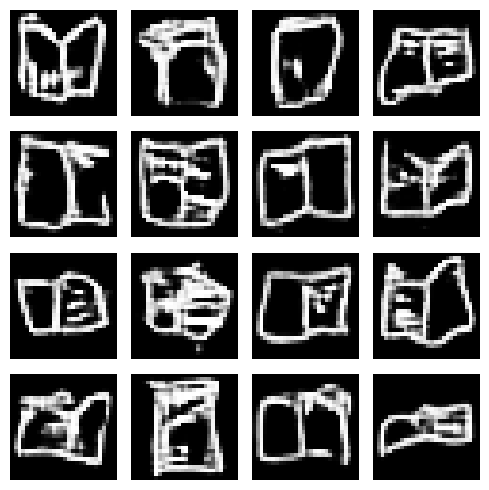

4/4 [==============================] - 0s 3ms/step
Epoch #1139
1139: [D loss: 0.410670, acc: 0.000000]  [A loss: 2.113082, acc: 0.118244]
1/1 [==============================] - 0s 22ms/step


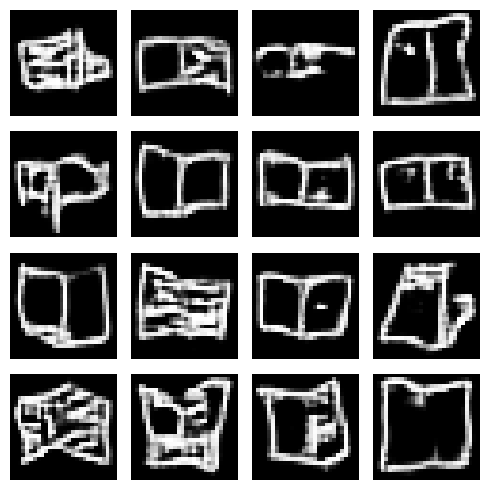

4/4 [==============================] - 0s 3ms/step
Epoch #1159
1159: [D loss: 0.409783, acc: 0.000000]  [A loss: 2.118154, acc: 0.117309]
1/1 [==============================] - 0s 19ms/step


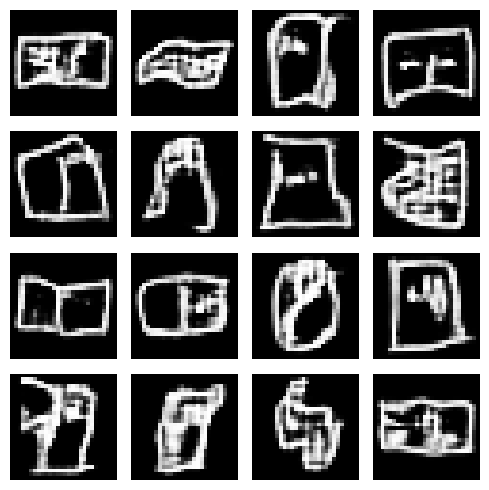

4/4 [==============================] - 0s 6ms/step
Epoch #1179
1179: [D loss: 0.408795, acc: 0.000000]  [A loss: 2.124098, acc: 0.116313]
1/1 [==============================] - 0s 26ms/step


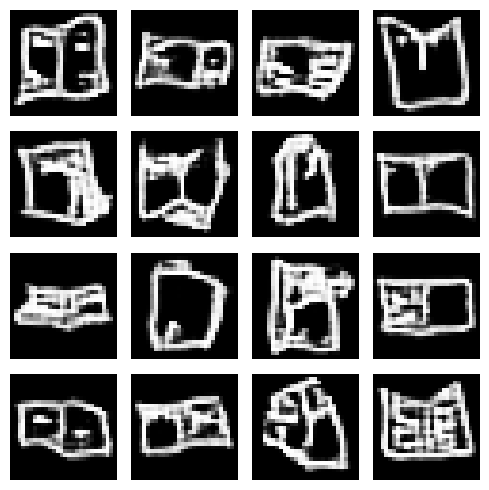

4/4 [==============================] - 0s 3ms/step
Epoch #1199
1199: [D loss: 0.407773, acc: 0.000000]  [A loss: 2.130106, acc: 0.115298]
1/1 [==============================] - 0s 18ms/step


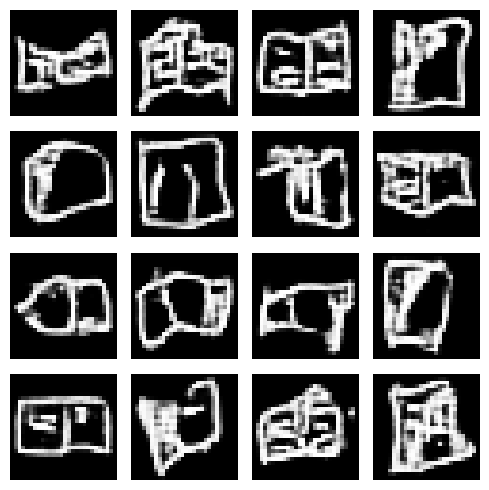

4/4 [==============================] - 0s 3ms/step
Epoch #1219
1219: [D loss: 0.406522, acc: 0.000000]  [A loss: 2.136986, acc: 0.114374]
1/1 [==============================] - 0s 23ms/step


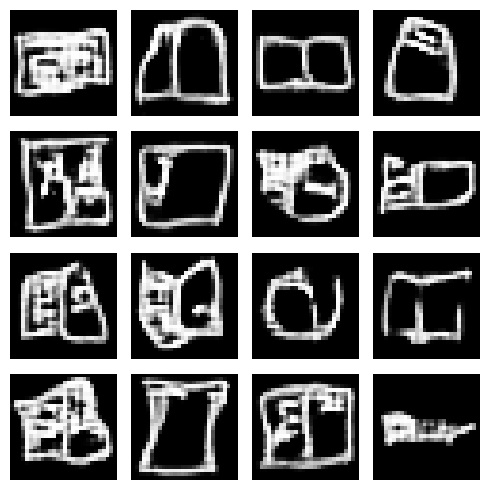

4/4 [==============================] - 0s 7ms/step
Epoch #1239
1239: [D loss: 0.405696, acc: 0.000000]  [A loss: 2.140894, acc: 0.113543]
1/1 [==============================] - 0s 32ms/step


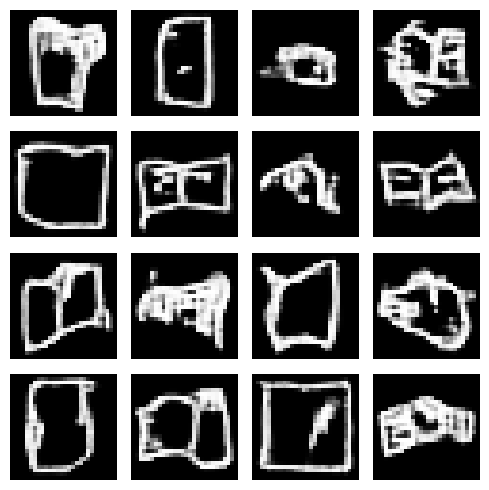

4/4 [==============================] - 0s 4ms/step
Epoch #1259
1259: [D loss: 0.404708, acc: 0.000000]  [A loss: 2.146017, acc: 0.112558]
1/1 [==============================] - 0s 20ms/step


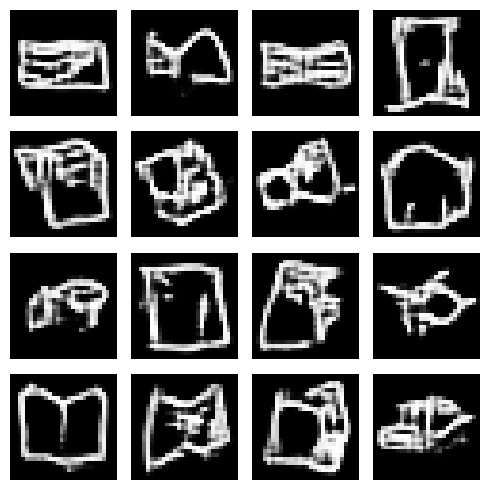

4/4 [==============================] - 0s 3ms/step
Epoch #1279
1279: [D loss: 0.403671, acc: 0.000000]  [A loss: 2.151418, acc: 0.111831]
1/1 [==============================] - 0s 27ms/step


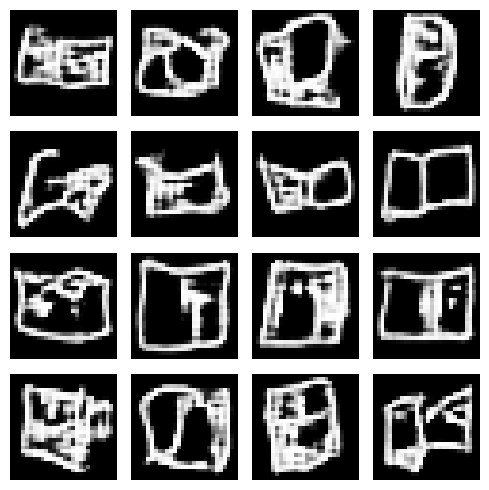

4/4 [==============================] - 0s 3ms/step
Epoch #1299
1299: [D loss: 0.402716, acc: 0.000000]  [A loss: 2.157077, acc: 0.110903]
1/1 [==============================] - 0s 26ms/step


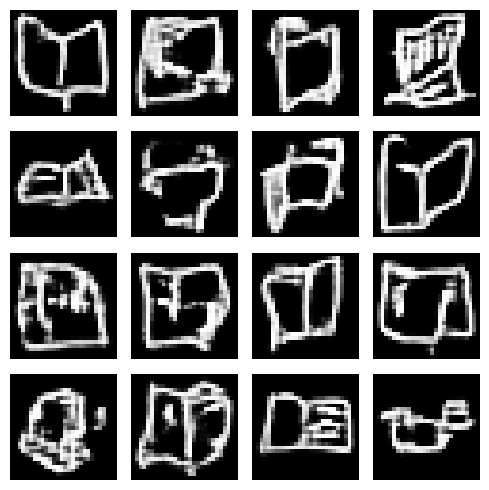

4/4 [==============================] - 0s 4ms/step
Epoch #1319
1319: [D loss: 0.401672, acc: 0.000000]  [A loss: 2.161987, acc: 0.110133]
1/1 [==============================] - 0s 31ms/step


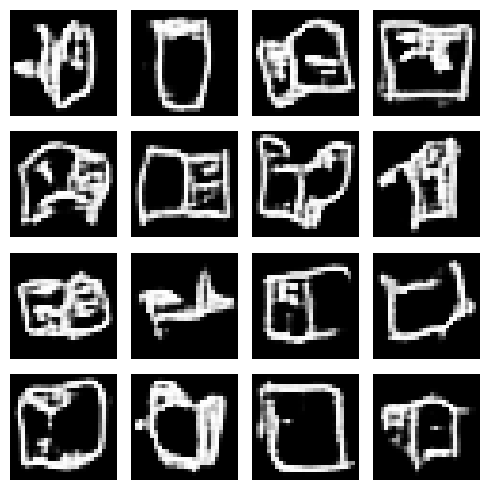

4/4 [==============================] - 0s 3ms/step
Epoch #1339
1339: [D loss: 0.400703, acc: 0.000000]  [A loss: 2.168016, acc: 0.109200]
1/1 [==============================] - 0s 22ms/step


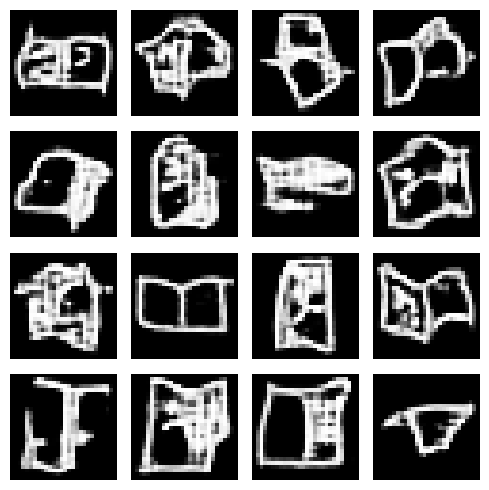

4/4 [==============================] - 0s 3ms/step
Epoch #1359
1359: [D loss: 0.399834, acc: 0.000000]  [A loss: 2.172839, acc: 0.108559]
1/1 [==============================] - 0s 23ms/step


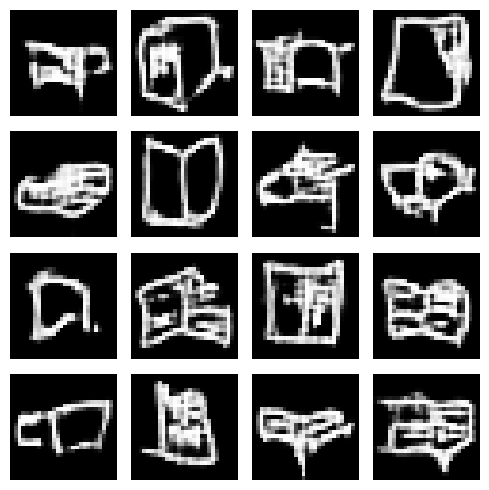

4/4 [==============================] - 0s 3ms/step
Epoch #1379
1379: [D loss: 0.398785, acc: 0.000000]  [A loss: 2.178443, acc: 0.107670]
1/1 [==============================] - 0s 18ms/step


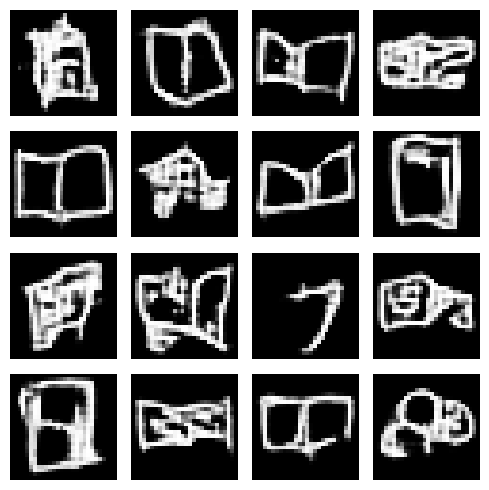

4/4 [==============================] - 0s 5ms/step
Epoch #1399
1399: [D loss: 0.397880, acc: 0.000000]  [A loss: 2.184089, acc: 0.106912]
1/1 [==============================] - 0s 26ms/step


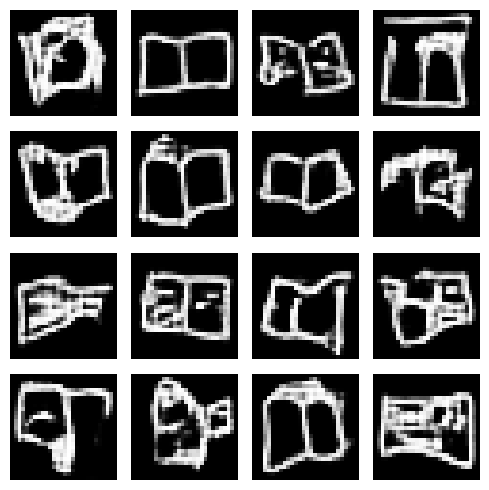

4/4 [==============================] - 0s 4ms/step
Epoch #1419
1419: [D loss: 0.396944, acc: 0.000000]  [A loss: 2.188997, acc: 0.106160]
1/1 [==============================] - 0s 26ms/step


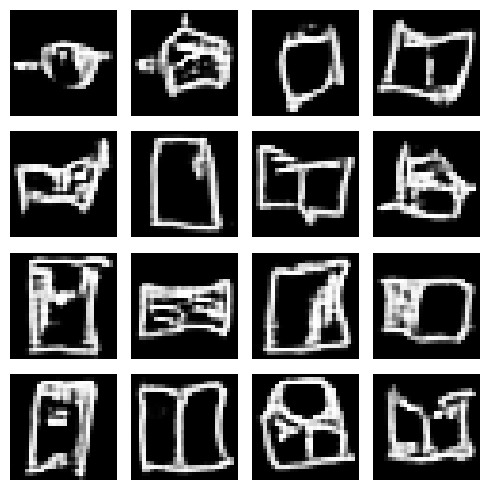

4/4 [==============================] - 0s 4ms/step
Epoch #1439
1439: [D loss: 0.395923, acc: 0.000000]  [A loss: 2.192612, acc: 0.105553]
1/1 [==============================] - 0s 28ms/step


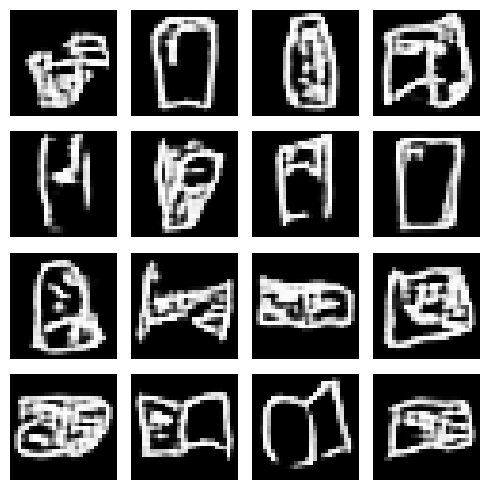

4/4 [==============================] - 0s 5ms/step
Epoch #1459
1459: [D loss: 0.395192, acc: 0.000000]  [A loss: 2.197181, acc: 0.104872]
1/1 [==============================] - 0s 25ms/step


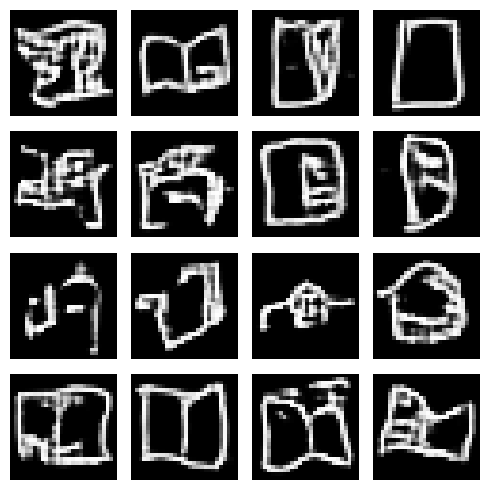

4/4 [==============================] - 0s 3ms/step
Epoch #1479
1479: [D loss: 0.394336, acc: 0.000000]  [A loss: 2.202176, acc: 0.104209]
1/1 [==============================] - 0s 17ms/step


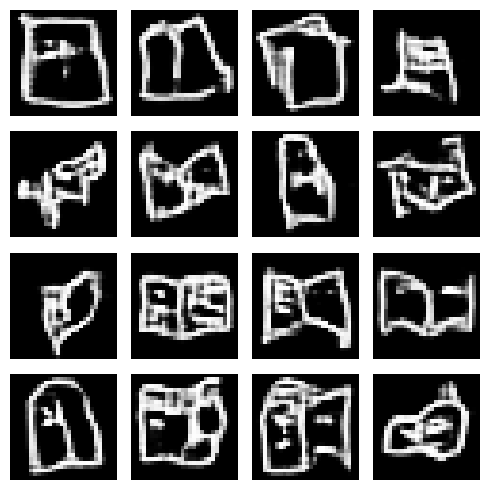

4/4 [==============================] - 0s 3ms/step
Epoch #1499
1499: [D loss: 0.393590, acc: 0.000000]  [A loss: 2.206078, acc: 0.103559]
1/1 [==============================] - 0s 17ms/step


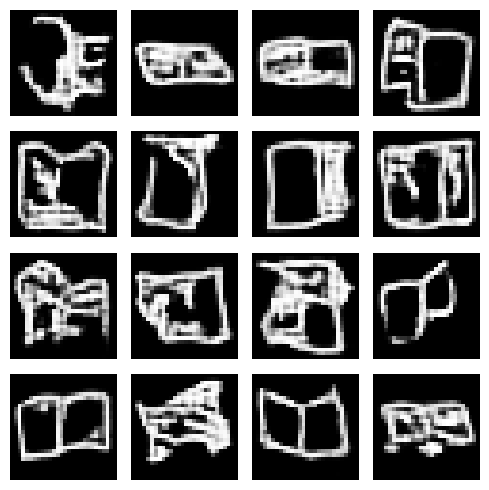

4/4 [==============================] - 0s 5ms/step
Epoch #1519
1519: [D loss: 0.392873, acc: 0.000000]  [A loss: 2.209852, acc: 0.102869]
1/1 [==============================] - 0s 24ms/step


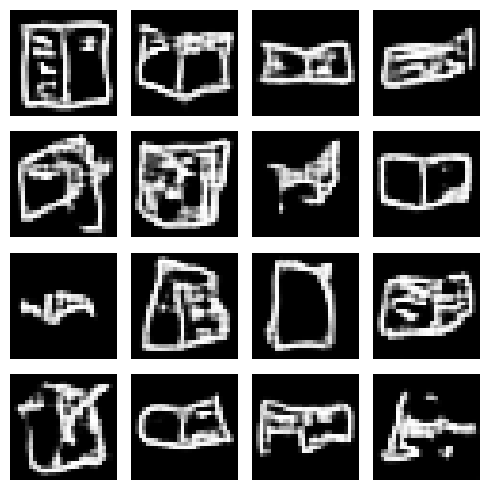

4/4 [==============================] - 0s 3ms/step
Epoch #1539
1539: [D loss: 0.392010, acc: 0.000000]  [A loss: 2.213736, acc: 0.102096]
1/1 [==============================] - 0s 22ms/step


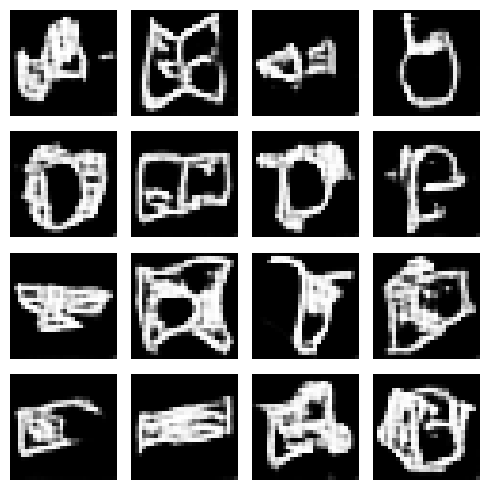

4/4 [==============================] - 0s 3ms/step
Epoch #1559
1559: [D loss: 0.391042, acc: 0.000000]  [A loss: 2.217903, acc: 0.101422]
1/1 [==============================] - 0s 17ms/step


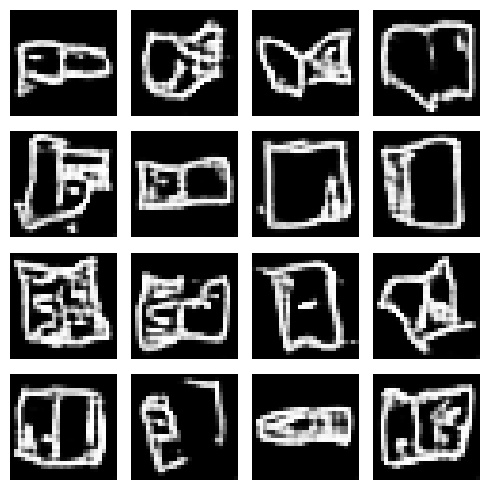

4/4 [==============================] - 0s 3ms/step
Epoch #1579
1579: [D loss: 0.390133, acc: 0.000000]  [A loss: 2.221718, acc: 0.100924]
1/1 [==============================] - 0s 26ms/step


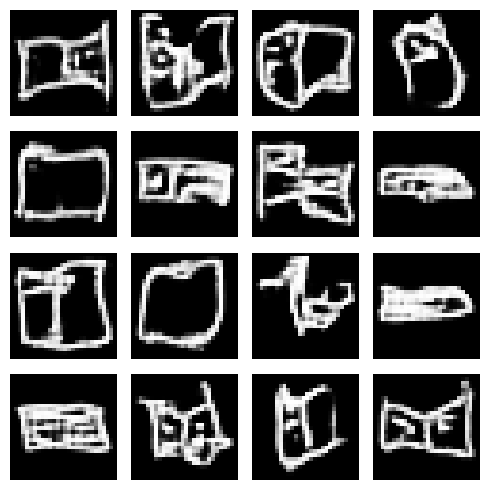

4/4 [==============================] - 0s 4ms/step
Epoch #1599
1599: [D loss: 0.389315, acc: 0.000000]  [A loss: 2.226301, acc: 0.100248]
1/1 [==============================] - 0s 23ms/step


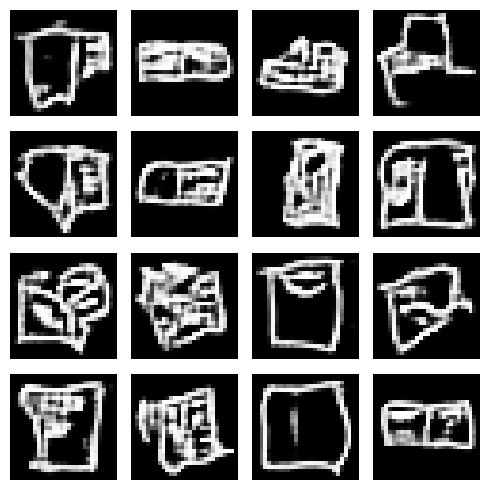

4/4 [==============================] - 0s 4ms/step
Epoch #1619
1619: [D loss: 0.388497, acc: 0.000000]  [A loss: 2.230351, acc: 0.099623]
1/1 [==============================] - 0s 18ms/step


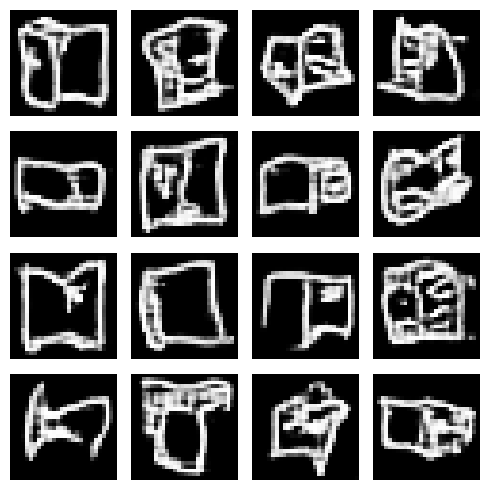

4/4 [==============================] - 0s 3ms/step
Epoch #1639
1639: [D loss: 0.387688, acc: 0.000000]  [A loss: 2.234416, acc: 0.098893]
1/1 [==============================] - 0s 18ms/step


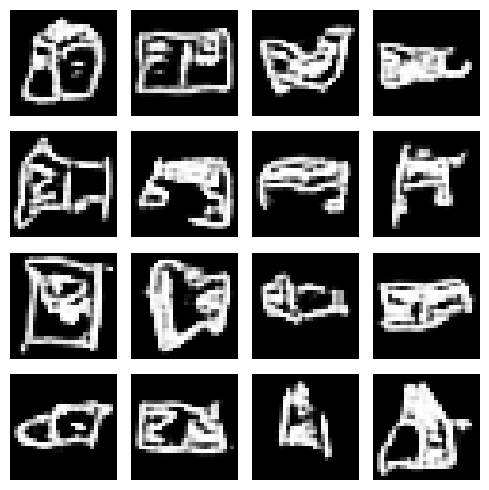

4/4 [==============================] - 0s 4ms/step
Epoch #1659
1659: [D loss: 0.387077, acc: 0.000000]  [A loss: 2.237605, acc: 0.098308]
1/1 [==============================] - 0s 23ms/step


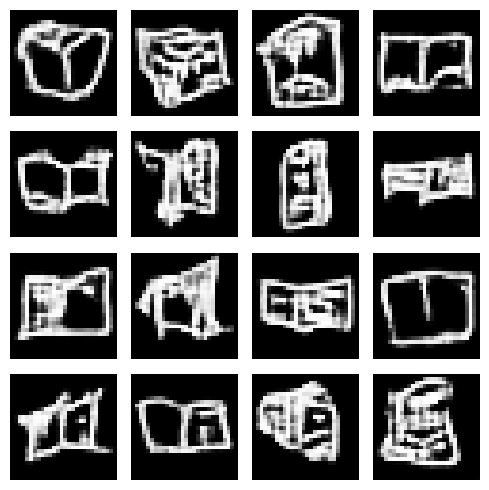

4/4 [==============================] - 0s 4ms/step
Epoch #1679
1679: [D loss: 0.386455, acc: 0.000000]  [A loss: 2.240142, acc: 0.097780]
1/1 [==============================] - 0s 30ms/step


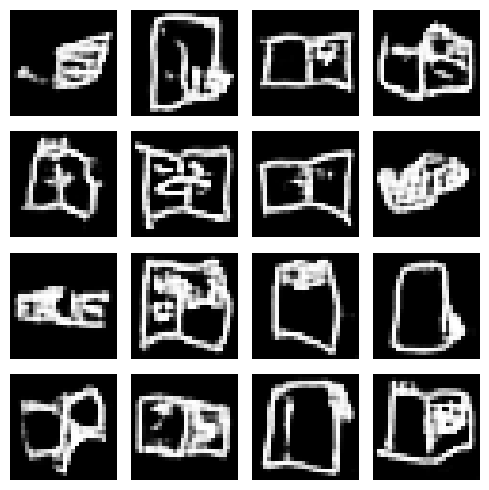

4/4 [==============================] - 0s 3ms/step
Epoch #1699
1699: [D loss: 0.385698, acc: 0.000000]  [A loss: 2.243934, acc: 0.097180]
1/1 [==============================] - 0s 27ms/step


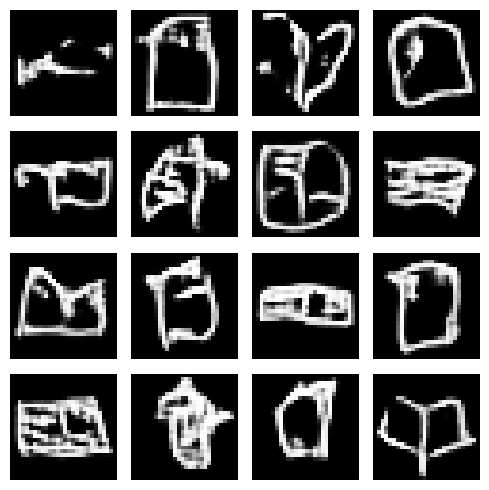

4/4 [==============================] - 0s 3ms/step
Epoch #1719
1719: [D loss: 0.384906, acc: 0.000000]  [A loss: 2.247194, acc: 0.096550]
1/1 [==============================] - 0s 24ms/step


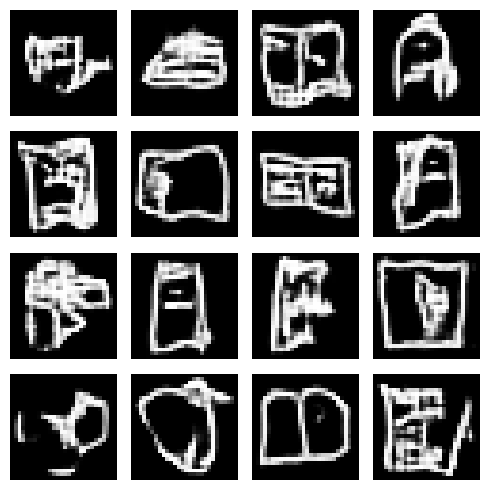

4/4 [==============================] - 0s 5ms/step
Epoch #1739
1739: [D loss: 0.384172, acc: 0.000000]  [A loss: 2.250485, acc: 0.095978]
1/1 [==============================] - 0s 25ms/step


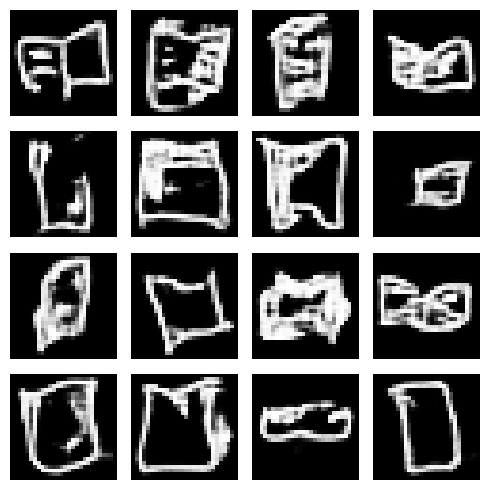

4/4 [==============================] - 0s 4ms/step
Epoch #1759
1759: [D loss: 0.383453, acc: 0.000000]  [A loss: 2.253808, acc: 0.095509]
1/1 [==============================] - 0s 17ms/step


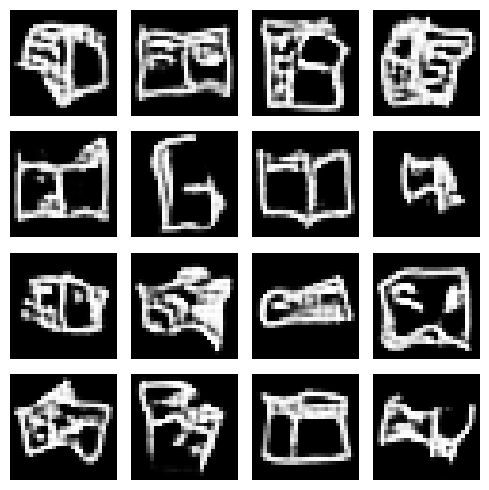

4/4 [==============================] - 0s 4ms/step
Epoch #1779
1779: [D loss: 0.382760, acc: 0.000000]  [A loss: 2.257578, acc: 0.094883]
1/1 [==============================] - 0s 30ms/step


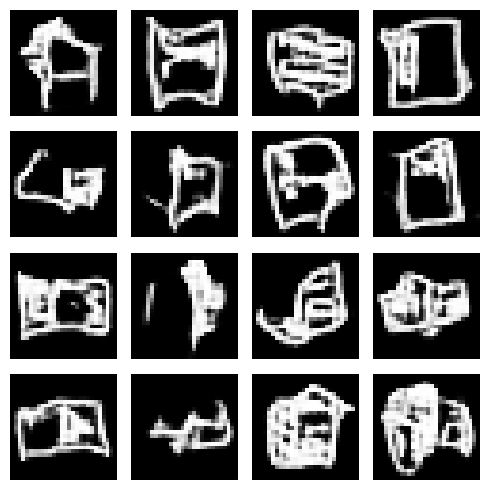

4/4 [==============================] - 0s 4ms/step
Epoch #1799
1799: [D loss: 0.382097, acc: 0.000000]  [A loss: 2.259944, acc: 0.094345]
1/1 [==============================] - 0s 30ms/step


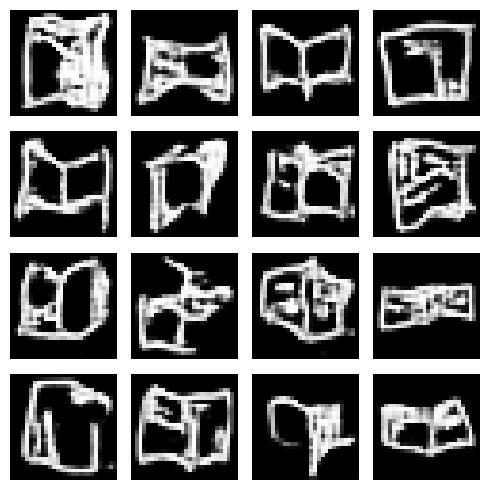

4/4 [==============================] - 0s 4ms/step
Epoch #1819
1819: [D loss: 0.381323, acc: 0.000000]  [A loss: 2.263707, acc: 0.093664]
1/1 [==============================] - 0s 26ms/step


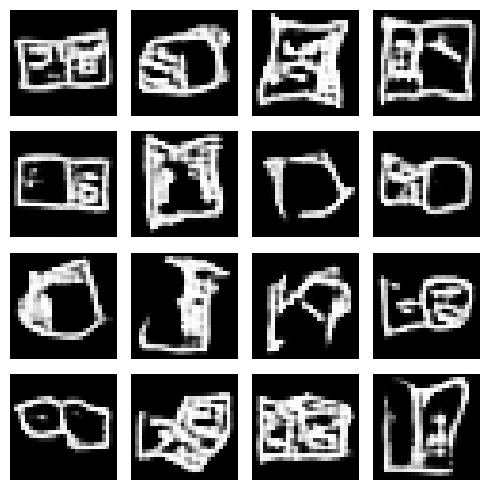

4/4 [==============================] - 0s 3ms/step
Epoch #1839
1839: [D loss: 0.380689, acc: 0.000000]  [A loss: 2.266421, acc: 0.093287]
1/1 [==============================] - 0s 25ms/step


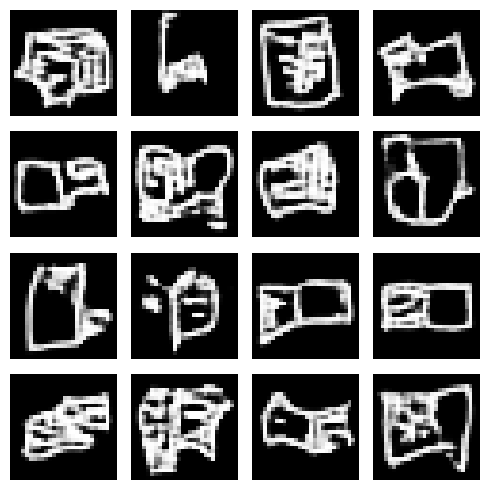

4/4 [==============================] - 0s 5ms/step
Epoch #1859
1859: [D loss: 0.380074, acc: 0.000000]  [A loss: 2.268904, acc: 0.092737]
1/1 [==============================] - 0s 22ms/step


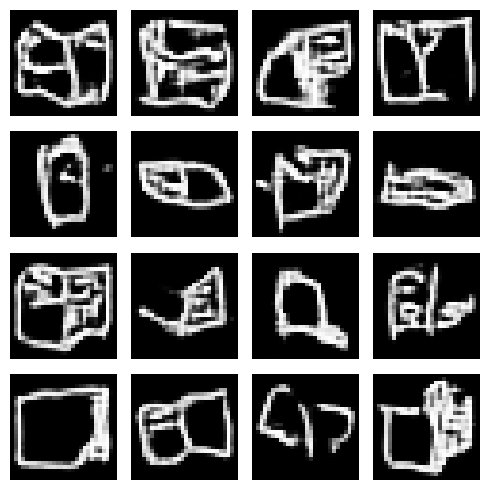

4/4 [==============================] - 0s 4ms/step
Epoch #1879
1879: [D loss: 0.379396, acc: 0.000000]  [A loss: 2.272370, acc: 0.092124]
1/1 [==============================] - 0s 21ms/step


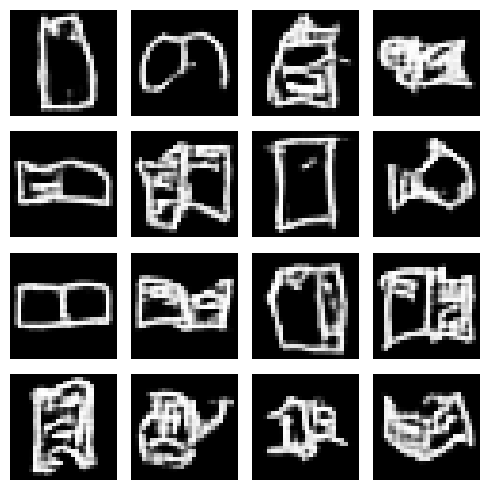

4/4 [==============================] - 0s 3ms/step
Epoch #1899
1899: [D loss: 0.378820, acc: 0.000000]  [A loss: 2.274941, acc: 0.091615]
1/1 [==============================] - 0s 26ms/step


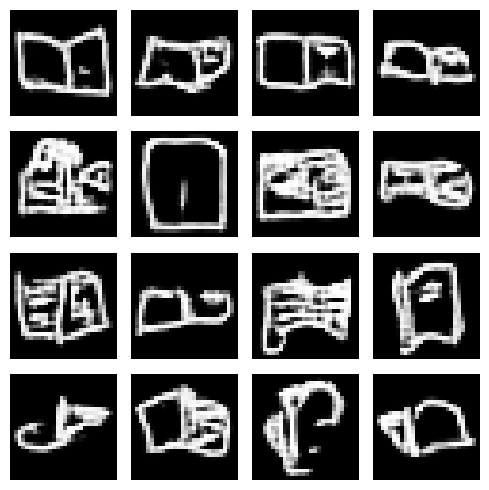

4/4 [==============================] - 0s 4ms/step
Epoch #1919
1919: [D loss: 0.378258, acc: 0.000000]  [A loss: 2.277856, acc: 0.091071]
1/1 [==============================] - 0s 30ms/step


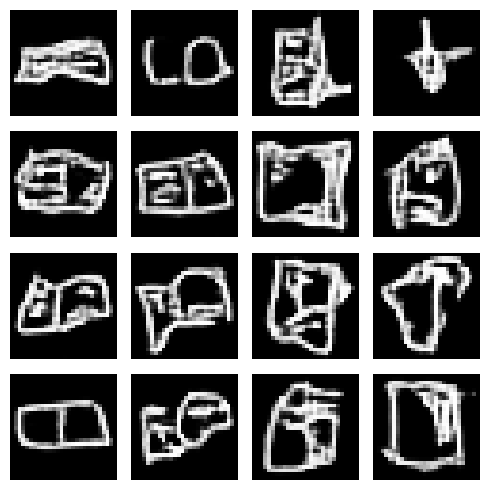

4/4 [==============================] - 0s 5ms/step
Epoch #1939
1939: [D loss: 0.377569, acc: 0.000000]  [A loss: 2.281096, acc: 0.090511]
1/1 [==============================] - 0s 23ms/step


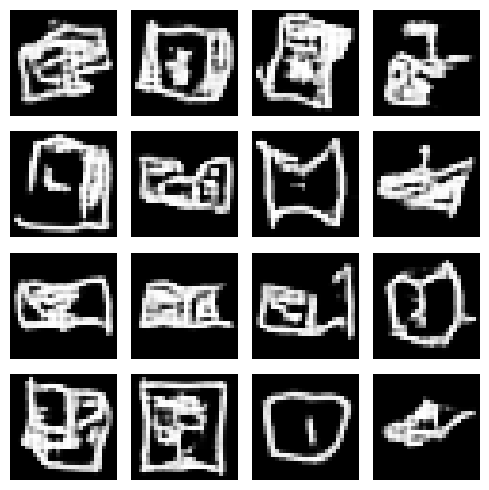

4/4 [==============================] - 0s 5ms/step
Epoch #1959
1959: [D loss: 0.377067, acc: 0.000000]  [A loss: 2.282928, acc: 0.090049]
1/1 [==============================] - 0s 30ms/step


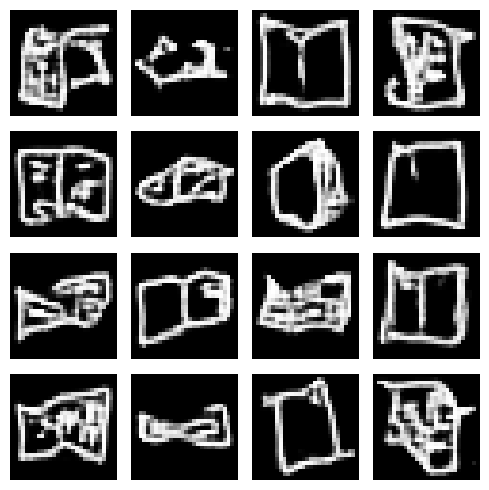

4/4 [==============================] - 0s 3ms/step
Epoch #1979
1979: [D loss: 0.376393, acc: 0.000000]  [A loss: 2.286468, acc: 0.089625]
1/1 [==============================] - 0s 21ms/step


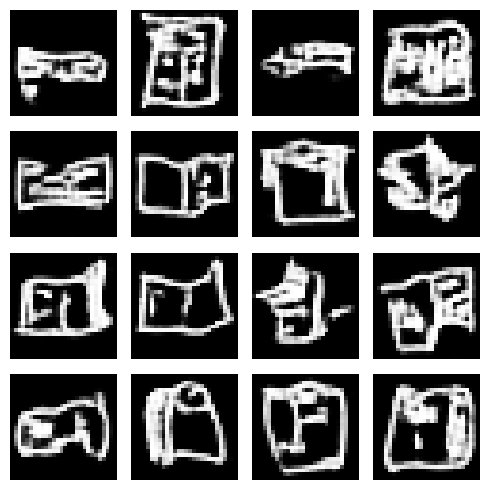

4/4 [==============================] - 0s 3ms/step
Epoch #1999
1999: [D loss: 0.375909, acc: 0.000000]  [A loss: 2.289114, acc: 0.089185]
1/1 [==============================] - 0s 26ms/step


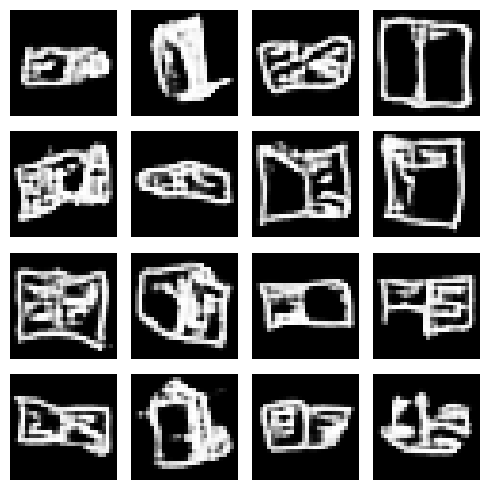

In [32]:
a_metrics_complete, d_metrics_complete = train()